In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd

from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
print(tf.__version__)

2.0.3


In [3]:
def plot_series(time, series, format="-", start=0, end=None, color=None, label=None):
    plt.plot(time[start:end], series[start:end], format, color=color, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
len(series)

1461

In [5]:
seed=42

In [6]:
np.random.RandomState(seed).randn(20)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])

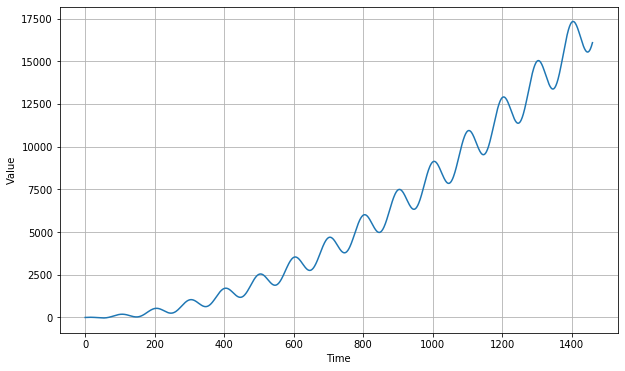

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time, trend(time, slope)**2 + time * np.cos(time * 2 * np.pi / 100)) 

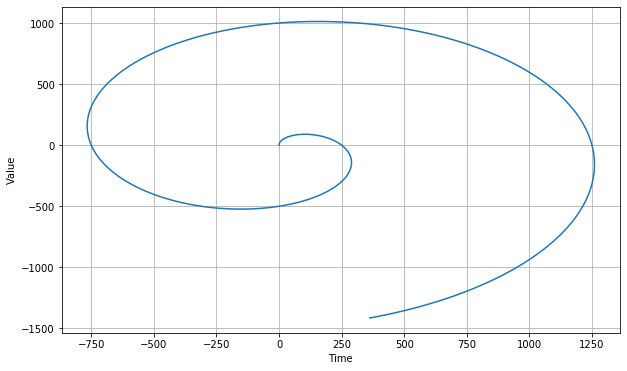

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time * np.sin(time * 2 * np.pi / 1000), time * np.cos(time * 2 * np.pi / 1000))

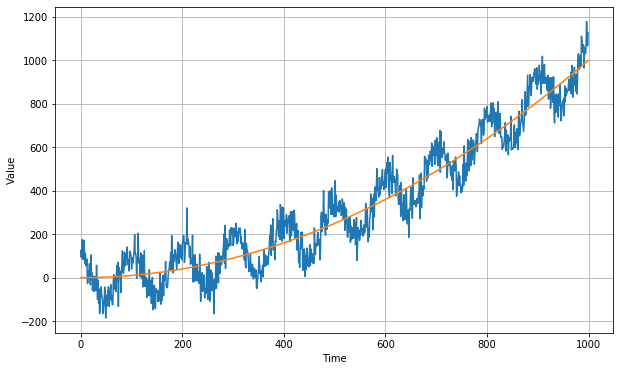

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time, time**2 /1000 + 100 * np.cos(time * 2 * np.pi / 100) + noise(time, noise_level=50, seed=42), end=1000)

plot_series(time, time**2 /1000, end=1000)

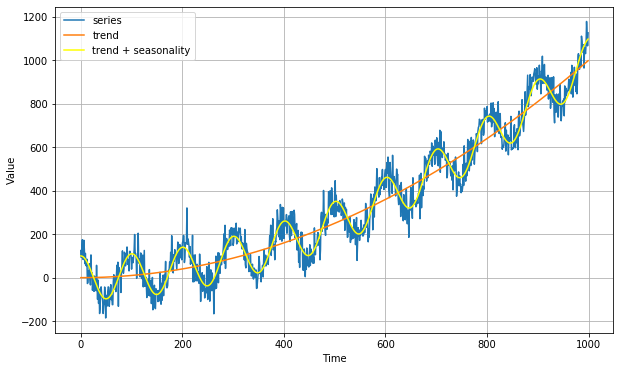

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time, time**2 /1000 + 100 * np.cos(time * 2 * np.pi / 100) + noise(time, noise_level=50, seed=42), end=1000, label='series')

plot_series(time, time**2 /1000, end=1000, label='trend')
plot_series(time, time**2 /1000 + 100 * np.cos(time * 2 * np.pi / 100), end=1000, color='yellow', label='trend + seasonality')

plt.legend()

In [11]:
filename = '2020-10-26 Spike Analysis brumbrum.xlsx'
df_tv = pd.read_excel(filename, sheet_name='tracciato_sessioni')

In [13]:
df_tv.head()

,date_time,bsl,dev,sessioni,baseline_post,dev_post,IS,NA,grp,new_IS,grp_tot,sessioni_non_matchate,lead,new_IS_rounded,n_week,Day of Week,date
0,2020-02-02 00:00:00,8.641622,2.235566,14,8.641622,2.235566,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6,D,2020-02-02
1,2020-02-02 00:01:00,5.121921,2.088921,6,5.121921,2.088921,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6,D,2020-02-02
2,2020-02-02 00:02:00,3.883809,1.651535,3,3.883809,1.651535,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6,D,2020-02-02
3,2020-02-02 00:03:00,3.079077,1.723889,1,3.079077,1.723889,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6,D,2020-02-02
4,2020-02-02 00:04:00,2.882360,1.714606,3,2.882360,1.714606,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6,D,2020-02-02


In [14]:
df_tv = df_tv[(df_tv['date'] >= '2020-02-09') & (df_tv['date'] < '2020-03-01')]

In [15]:
time_tv = df_tv['date_time'].to_numpy()
sessioni_tv =  df_tv['sessioni'].to_numpy()

<Figure size 1296x432 with 0 Axes>

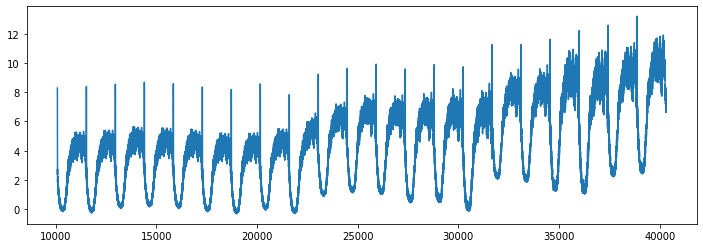

In [16]:
plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_tv['bsl'], label='baseline')

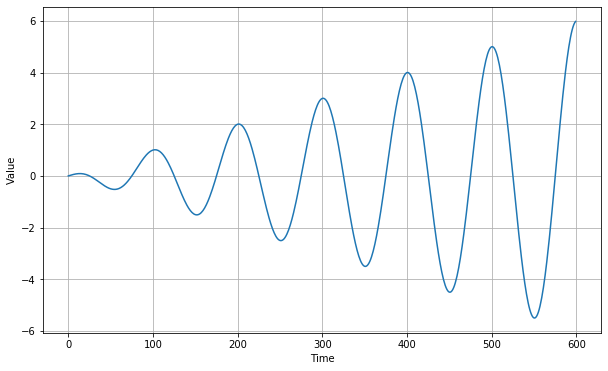

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time, time / 100 * np.cos(time * 2 * np.pi / 100), end=600) 

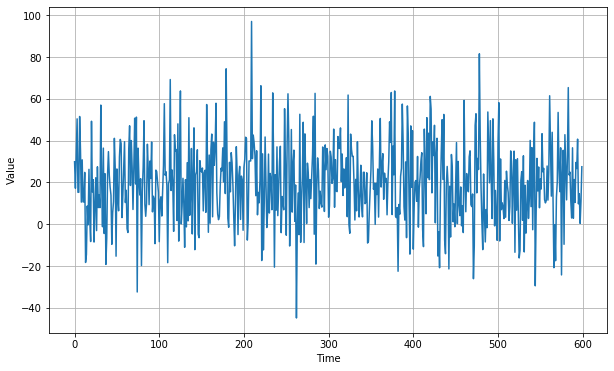

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time, 20 + noise(time, noise_level=20, seed=42), end=600) 

In [19]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

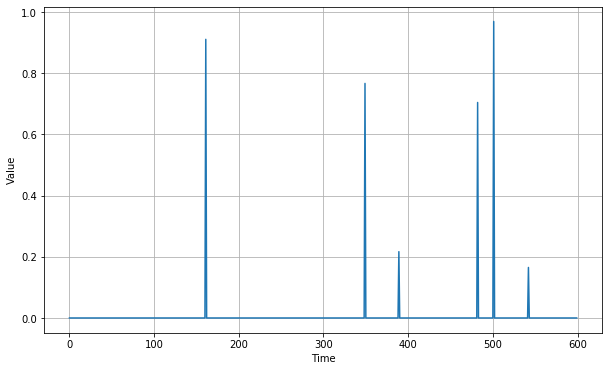

In [20]:
plt.figure(figsize=(10, 6))
series = impulses(time, 200)
plot_series(time, series, end=600)
plt.show()

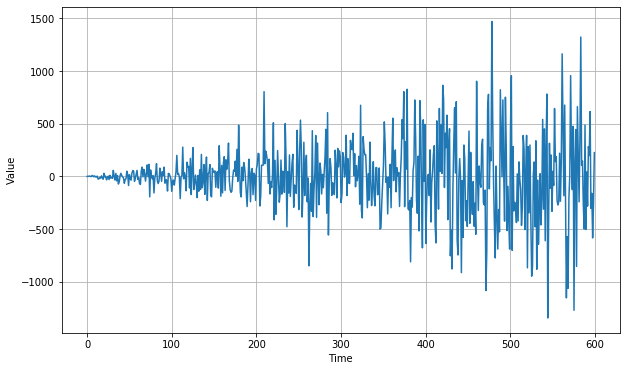

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time, noise(time, noise_level=time, seed=42), end=600) 

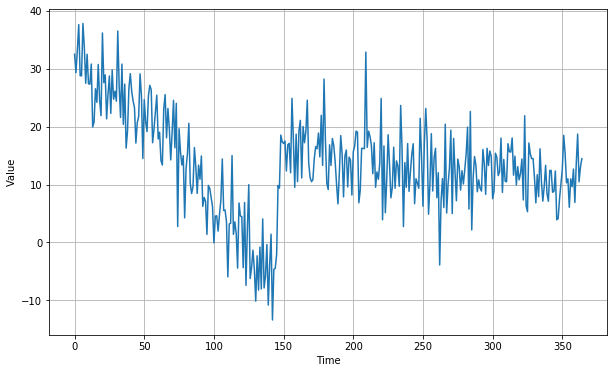

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time, baseline + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level=noise_level, seed=42), end=365) 



<Figure size 1296x432 with 0 Axes>

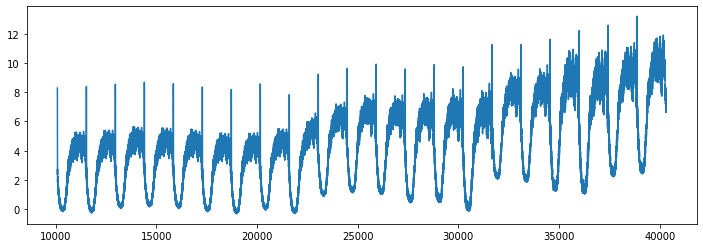

In [23]:
plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_tv['bsl'], label='baseline')

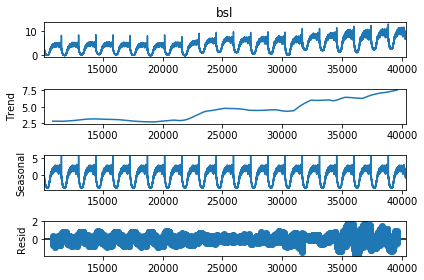

In [24]:
result = seasonal_decompose(df_tv['bsl'], model='additive', period=1440)
result.plot()
pyplot.show()

<Figure size 1296x432 with 0 Axes>

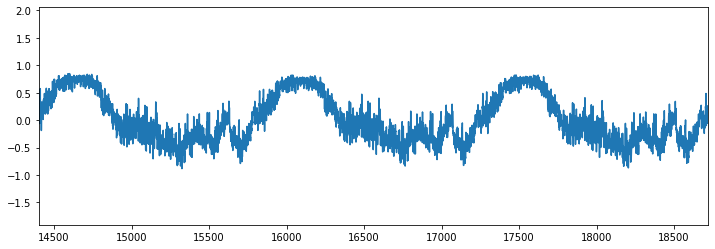

In [30]:
plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.xlim((10080+1440*3, 10080+1440*6))
ax.plot(result.resid, label='baseline')

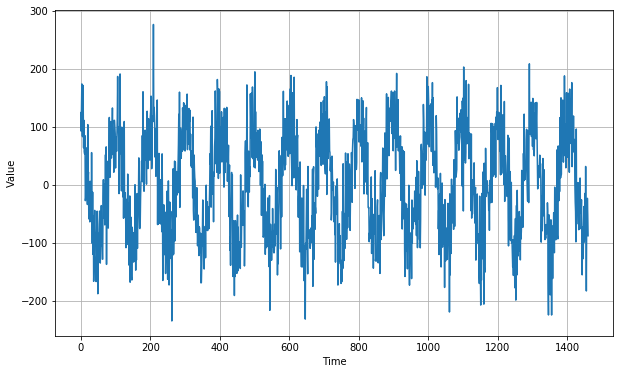

In [26]:
plt.figure(figsize=(10, 6))

serie =  100 * np.cos(time * 2 * np.pi / 100) + noise(time, noise_level=50, seed=42)
plot_series(time, serie)

#plot_series(time, time**2 /1000, end=1000)

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

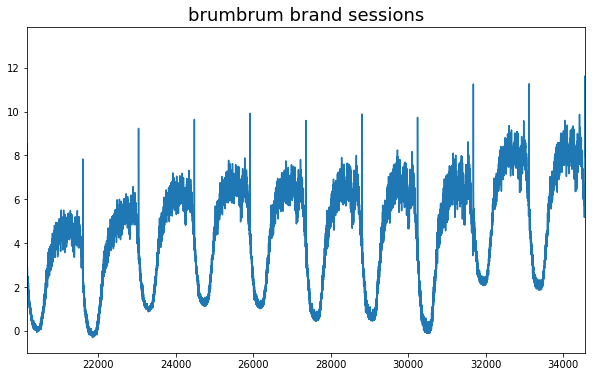

In [28]:
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xlim((20160, 20160+1440*10))
ax.plot(df_tv['bsl'], label='baseline')
ax.set_title('brumbrum brand sessions', fontsize=18)
plt.show()

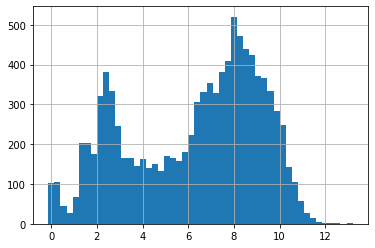

In [29]:
df_tv['bsl'].iloc[20160:].hist(bins=50)

<Figure size 720x432 with 0 Axes>

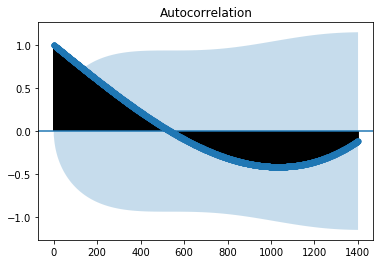

In [30]:
plt.figure(figsize=(10, 6))

plot_acf(2*time, lags = 1400)
plt.show()

<Figure size 720x432 with 0 Axes>

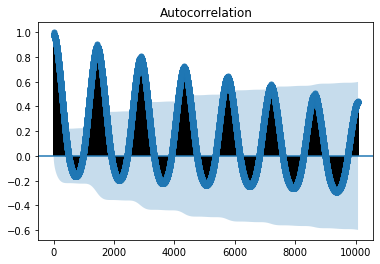

In [31]:
plt.figure(figsize=(10, 6))

plot_acf(df_tv['bsl'], lags = 10080)
pyplot.show()

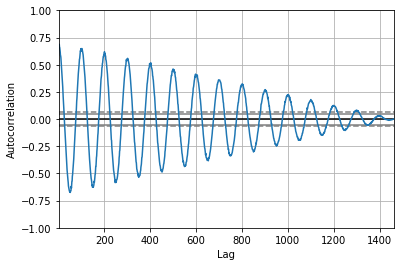

In [32]:
autocorrelation_plot(serie)
pyplot.show()

## autoregressive model


In [33]:
naive_forecast = series[split_time - 1:-1]

In [34]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [35]:
sqrt(mean_squared_error(x_valid, naive_forecast))

125.13254865738594

In [36]:
# create and evaluate an updated autoregressive model


# load dataset
# 22.7. Autoregression Model 197
# split dataset
# X = series
# train, test = X[1:len(X)-split_time], X[len(X)-split_time:]
# train autoregression
model = AR(x_train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = x_train[len(x_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(x_valid)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = x_valid[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(x_valid, predictions))
print('Test RMSE: %.3f' % rmse)
# plot


Test RMSE: 5.730


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn

In [37]:
len(coef)

22

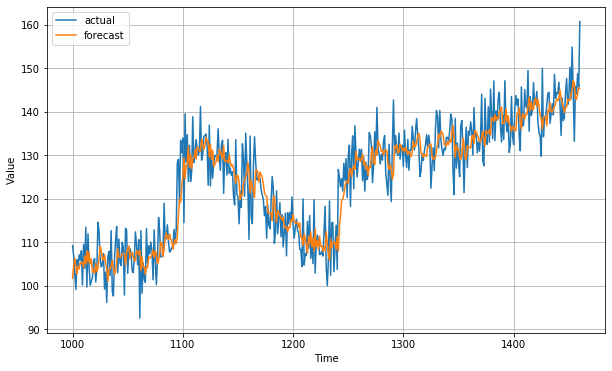

In [38]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='actual')
plot_series(time_valid, predictions, label='forecast')
plt.legend()

plt.show()

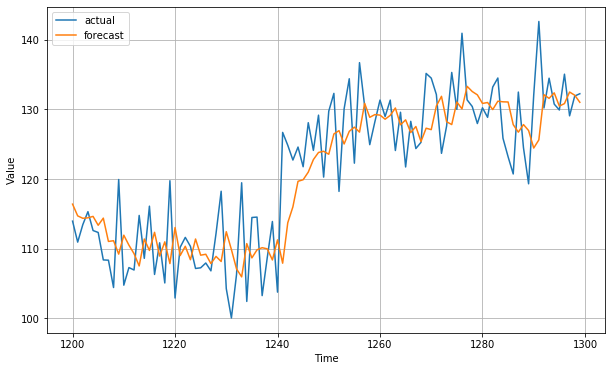

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[200:300], x_valid[200:300], label='actual')
plot_series(time_valid[200:300], predictions[200:300], label='forecast')
plt.legend()
pyplot.show()

## moving average model

In [40]:
series_diff = series[1:] - series[:-1]

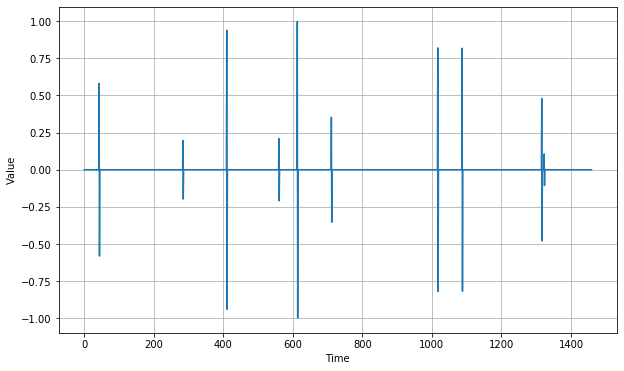

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time[:-1], series_diff)

plt.show()

In [42]:
split_time = 1000
time_train_diff = time[:split_time-1]
x_train_diff = series_diff[:split_time]
time_valid_diff = time[split_time+1:]
x_valid_diff = series_diff[split_time:]

In [43]:
model = AR(x_train_diff)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = x_train_diff[len(x_train_diff)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(x_valid_diff)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = x_valid_diff[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(x_valid_diff, predictions))
print('Test RMSE: %.3f' % rmse)
# plot

Test RMSE: 0.060


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn

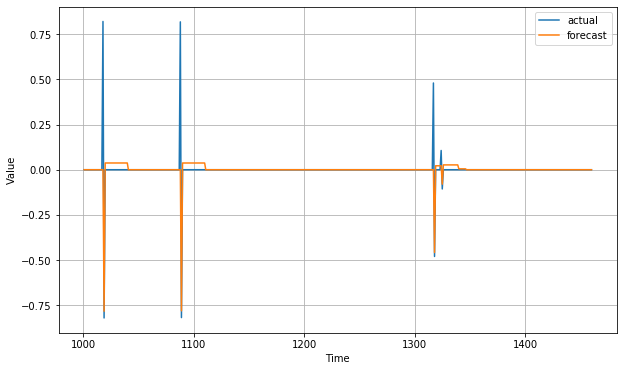

In [44]:
plt.figure(figsize=(10, 6))
plot_series(time_valid_diff, x_valid_diff, label='actual')
plot_series(time_valid_diff, predictions, label='forecast')
plt.legend()

plt.show()

## ARIMA

In [45]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

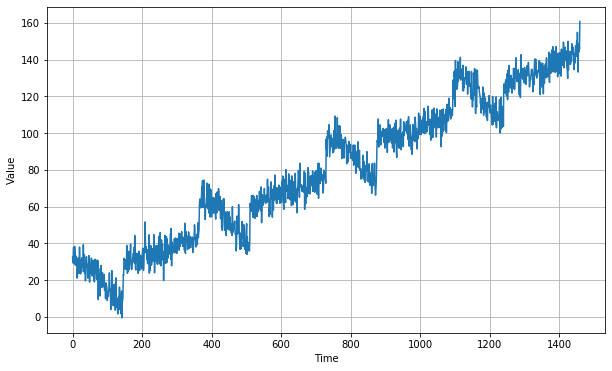

In [46]:
plt.figure(figsize=(10, 6))

plot_series(time, series)

In [47]:
arima

NameError: name 'arima' is not defined

In [ ]:
plt.figure(figsize=(10, 6))

plot_acf(series, lags=100)
pyplot.show()

In [ ]:
plt.figure(figsize=(10, 6))

plot_pacf(series)
pyplot.show()

In [ ]:
# fit model
# def parser(x):
# return datetime.strptime('190'+x, '%Y-%m')
# series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True,
# squeeze=True, date_parser=parser)
# split into train and test sets
# X = series.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
history = [x for x in x_train]
predictions = list()
# walk-forward validation
for t in range(len(x_valid)):
    model = ARIMA(history, order=(8,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = x_valid[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(x_valid, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
# pyplot.plot(x_valid)
# pyplot.plot(predictions)
# pyplot.show()

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='actual')
plot_series(time_valid, predictions, label='forecast')
plt.legend()
pyplot.show()

## exp smoothing

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
alphas = [i*0.1 for i in range(1,10)] 

In [ ]:
for alpha in alphas:
    history = [x for x in x_train]
    predictions = list()
# walk-forward validation

    for t in range(len(x_valid)):
        model = SimpleExpSmoothing(history)
        model_fit = model.fit(smoothing_level=alpha)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = x_valid[t]
        history.append(obs)
       # print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(x_valid, predictions))
    print('Test RMSE: %.3f' % rmse)

In [ ]:
history = [x for x in x_train]
predictions = list()
# walk-forward validation

for t in range(len(x_valid)):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=0.2)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = x_valid[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(x_valid, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='actual')
plot_series(time_valid, predictions, label='forecast')
plt.legend()
pyplot.show()

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[200:300], x_valid[200:300], label='actual')
plot_series(time_valid[200:300], predictions[200:300], label='forecast')
plt.legend()
pyplot.show()

In [ ]:
time_valid[200:300]

## MLP

In [48]:
mlp

NameError: name 'mlp' is not defined

In [49]:
# split a univariate sequence into samples
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [50]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


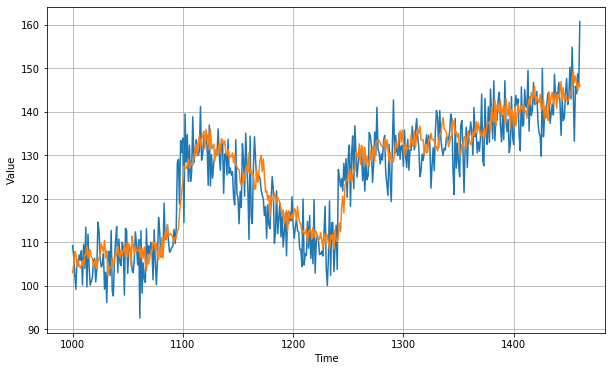

In [51]:
forecast = []
for time in range(len(series) - window_size):
  
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [52]:
np.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

5.997311

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
# print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [ ]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
np.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

In [32]:
filename = 'tracciato tv 2019 limit.xlsx'
df_tv_agosto = pd.read_excel(filename)

In [37]:
df_tv_solo_agosto = df_tv_agosto[df_tv_agosto['date_time'] < '2019-09-01']

In [38]:
df_tv_solo_agosto.head()

,date_time,sessioni,bsl,dev,IS,NA,grp,new_IS,grp_tot,IS_pesati,sessioni_non_matchate,sessions_not_matched_to_baseline,new_baseline_raw,sessioni_to_baseline,new_baseline,new_dev,new_IS_rounded,n_week,date,sessioni_brand
0,2019-08-18 00:00:00,3,2.829003,0.956090,0.0,0.170997,0.0,0.0,0.0,0.0,0.0,0.0,2.829003,3.0,4.451738,0.956090,0,34,2019-08-18,1
1,2019-08-18 00:01:00,0,1.092115,0.867127,0.0,-1.092115,0.0,0.0,0.0,0.0,0.0,0.0,1.092115,0.0,2.432246,0.867127,0,34,2019-08-18,0
2,2019-08-18 00:02:00,0,0.826868,0.866675,0.0,-0.826868,0.0,0.0,0.0,0.0,0.0,0.0,0.826868,0.0,2.039894,0.866675,0,34,2019-08-18,0
3,2019-08-18 00:03:00,2,0.796935,0.819901,0.0,1.203065,0.0,0.0,0.0,0.0,0.0,0.0,0.796935,2.0,2.265090,0.819901,0,34,2019-08-18,1
4,2019-08-18 00:04:00,0,0.855554,0.824284,0.0,-0.855554,0.0,0.0,0.0,0.0,0.0,0.0,0.855554,0.0,2.022471,0.824284,0,34,2019-08-18,0


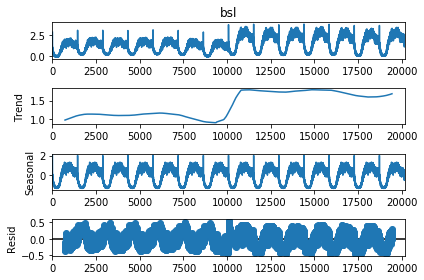

In [39]:
result = seasonal_decompose(df_tv_solo_agosto['bsl'], model='additive', period=1440)
result.plot()
pyplot.show()

<Figure size 1296x432 with 0 Axes>

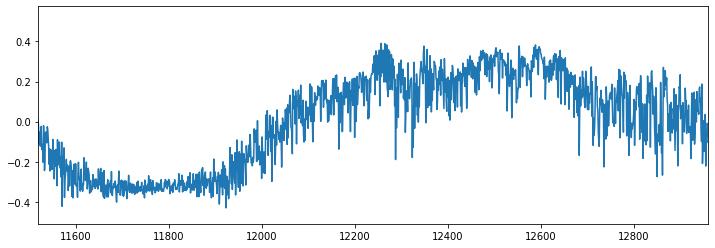

In [43]:
plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.xlim((10080+1440*1, 10080+1440*2))
ax.plot(result.resid, label='resid')